In [1]:
from tomographic_lensing import *
from CovMat import *
import gc

In [2]:
# Input Cosmology object with a given set of parameters
cosmo = ccl.Cosmology(
    Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96,
    transfer_function='bbks')

ell = np.arange(2, 10001)

In [3]:
dndz1=GalaxyDistr(zi=0.001, zf=4.0, n_eff=10.024, z0=0.13, alpha=0.78)
#n_eff is chosen from the last column of Table F1,"https://arxiv.org/abs/1809.01669" LSST Science Requirements Document
#z0 and alpha are from Figure F4, Y1 of the same document

In [4]:
arcmin_per_str=(180*60/np.pi)**2
#how many square arcminutes are there in a steradian 
num_den = arcmin_per_str*10.024

In [5]:
# create bins of dndz using A.equal redshift bins, and B.equal galaxy number bins
def sliced_equal_z(dndz, nbins_z):
    n = nbins_z
    min_z = dndz[ :, 0].min()
    inc = (dndz[ :, 0].max()-min_z)/n
    #this calculates the increment in refshifts for each bin
    dndz_cut = {}
    #create an empty dictionary for sliced galaxy number density distribution
    for i in range(n):
        dndz_cut["bin_{}".format(i)] = dndz[np.logical_and(dndz[:,0]>inc*i+min_z, dndz[:,0]<inc*(i+1)+min_z)]
    return dndz_cut

def sliced_equal_n(dndz, nbins_z):
    n = nbins_z
    cdf = np.array([np.sum(dndz1[:i+1,1]) for i in range(len(dndz1[:,1]))])
    #find the cumulative density function
    inc = cdf[-1]/n
    #cdf[-1] gives the total number of galaxies in the sky. each bin has total/n galaxies
    dndz_cut = {}
    #create an empty dictionary for sliced galaxy number density distribution
    for i in range(n):
        dndz_cut["bin_{}".format(i)] = dndz[np.logical_and(cdf>inc*i, cdf<inc*(i+1))]
    return dndz_cut

In [6]:
def getCl(dndz_sliced, ell, cosmo):
    """This function calculats auto- and cross-power spectra for given sliced galaxy-redshift distribution."""
    n = len(dndz_sliced);
    lens = [[]]*n
    for i, dndz in enumerate(dndz_sliced.values()):
        lens[i] = ccl.WeakLensingTracer(cosmo, dndz=(dndz[:,0], dndz[:,1]))
    #create an empty n-by-n array that stores the lensing cross power spectrum between the ith and jth bin
    cl=[]
    for j in range(n):
        cl.extend(ccl.angular_cl(cosmo, lens[j], lens[j+i], ell) for i in range(n-j))
    cl_arr = np.array(cl)
    return cl_arr

In [7]:
def getCovMat(fsky, n_bins, cl, ell, dndz, dndz1, numdenPerStr):
    l = []
    for j in range(n_bins):
        l.extend([[j, j+i] for i in range(n_bins-j)])
    cl_bin = np.vstack((ell, cl)).T
    #for number density, divide galaxy numbers into each tomographic bin
    numden = np.array([(np.sum(dndz["bin_{}".format(i)][:, 1])/np.sum(dndz1[:,1]))*numdenPerStr for i in range(n_bins)])
    cov_arr = np.array(multi_bin_cov(fsky, cl_bin, np.array(l), numden))
    return cov_arr

In [8]:
np.sum(dndz1[:,1])

1488670860.8310428

In [9]:
cl = {} 
cov = {}
sliced_dndz = {}

for rbins in [5]:
    for rbin_type in ["z", "n"]:
        if rbin_type == "z":
            sliced_dndz["{0}_{1}".format(rbin_type, rbins)] = sliced_equal_z(dndz1, rbins)
        else:
            sliced_dndz["{0}_{1}".format(rbin_type, rbins)] = sliced_equal_n(dndz1, rbins)
        cl["{0}_{1}".format(rbin_type, rbins)] = getCl(sliced_dndz["{0}_{1}".format(rbin_type, rbins)], ell, cosmo)
        cov["{0}_{1}".format(rbin_type, rbins)] = getCovMat(fsky=0.4, n_bins=rbins, cl=cl["{0}_{1}".format(rbin_type, rbins)], ell=ell, dndz= sliced_dndz["{0}_{1}".format(rbin_type, rbins)], dndz1=dndz1, numdenPerStr=num_den)


In [10]:
def SignalToNoise_o(cl, cov):
    """calculate the signal to noise for the given cl signal, and covariance array, without binning in l"""
    stn_sq = 0
    for i in range(cl.shape[1]):
        stn_sq = stn_sq + np.matmul(cl[:, i].T, 
                                    np.matmul(np.linalg.inv(cov[i,:,:]), cl[:, i]))
    stn = np.sqrt(stn_sq)
    return stn

In [11]:
stn = {}
for i in ["z", "n"]:
    for j in [5]:
        stn["{0}_{1}".format(i,j)] = SignalToNoise_o(cl = cl["{0}_{1}".format(i, j)], cov = cov["{0}_{1}".format(i, j)])

In [12]:
stn

{'z_5': 95.3093909508607, 'n_5': 45.363703254148525}

In [13]:
#check 5 tomographic bins: how much does each bin contribute to the total signal to noise
l = []
for j in range(5):
    l.extend([[j, j+i] for i in range(5-j)])

In [14]:
l

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 2],
 [2, 3],
 [2, 4],
 [3, 3],
 [3, 4],
 [4, 4]]

In [15]:
cl["z_5"].shape

(15, 9999)

In [16]:
cov["z_5"][:, 0, 0].shape

(9999,)

In [17]:
def SignalToNoise_bin(cl, cov):
    """calculate the signal to noise for the given cl signal, and covariance array, without binning in z"""
    stn_sq = 0
    for i in range(len(cl)):
        stn_sq = stn_sq + cl[i]**2/cov[i]
    stn = np.sqrt(stn_sq)
    return stn

In [19]:
for i in ["z", "n"]:
    for j in [0, 5, 9, 12, 14]:
        stn["{0}_5_bin_{1}".format(i,j+1)] = SignalToNoise_bin(cl = cl["{0}_5".format(i)][j], cov = cov["{0}_5".format(i)][:, j, j])

In [20]:
stn["z_5_bin_1"]

0.033976263475357975

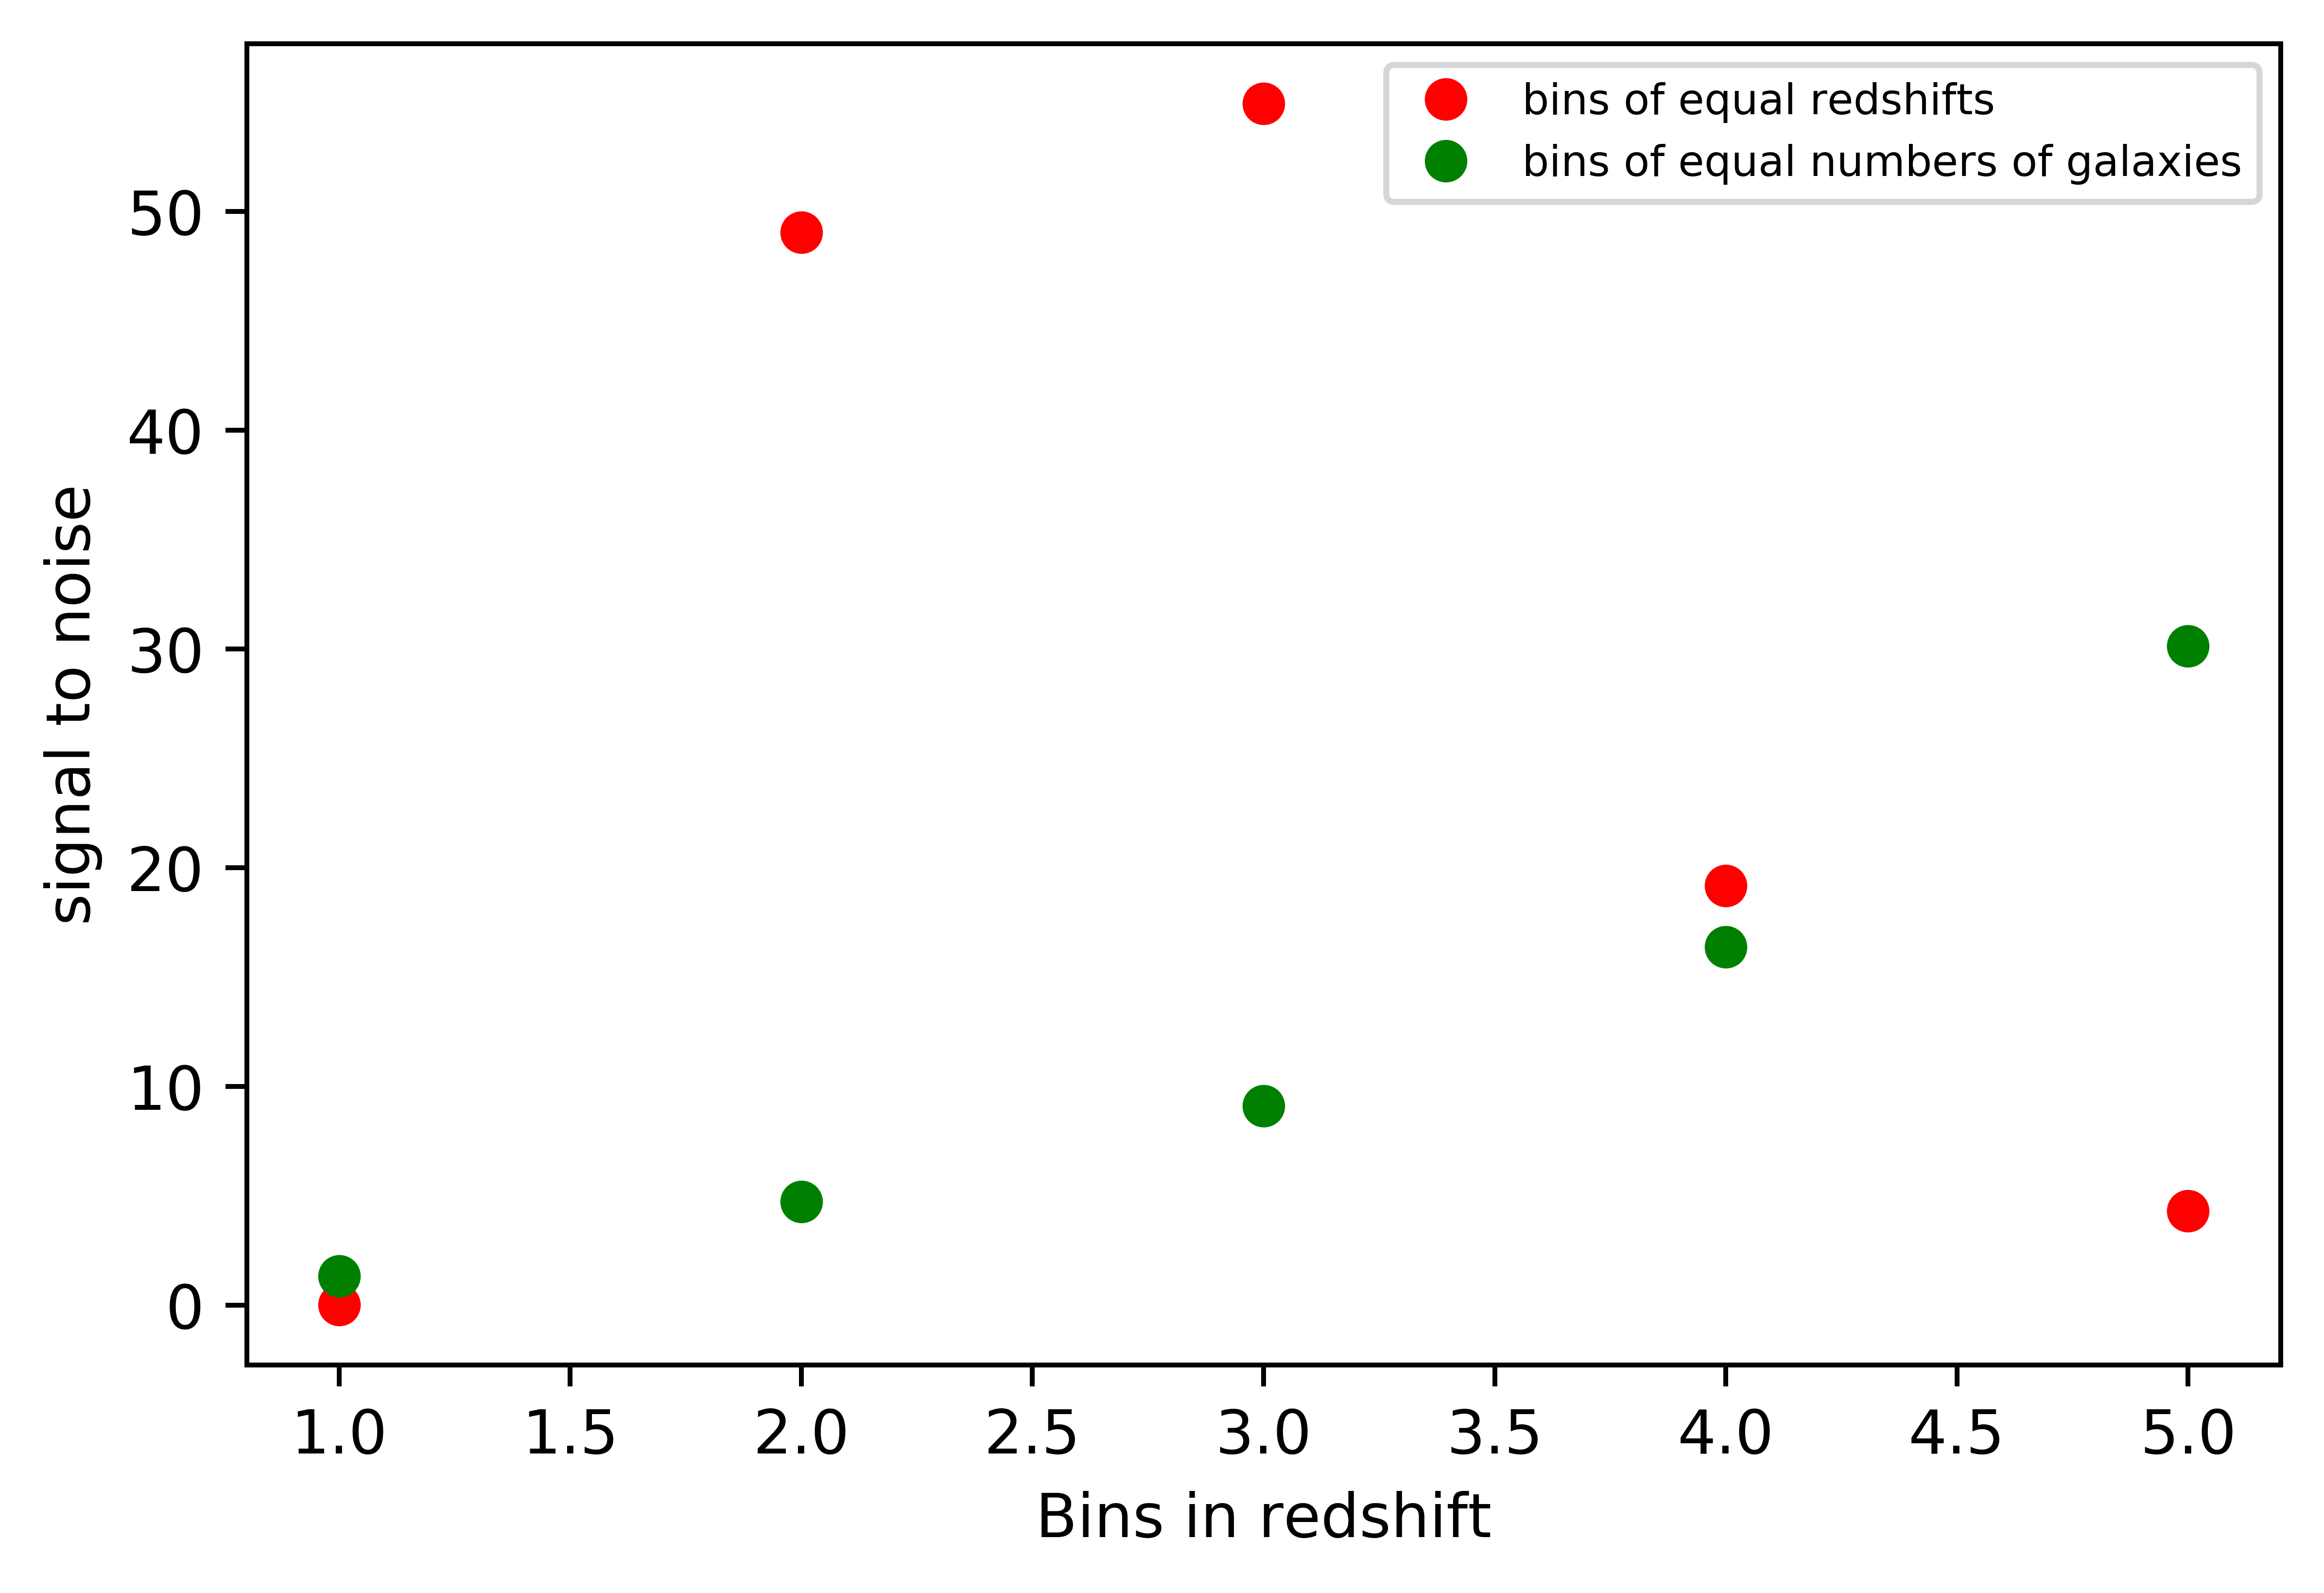

In [21]:
params = {'legend.fontsize': 7,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4, 5], [stn["z_5_bin_1"], stn["z_5_bin_6"], stn["z_5_bin_10"], stn["z_5_bin_13"], stn["z_5_bin_15"]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4, 5], [stn["n_5_bin_1"], stn["n_5_bin_6"], stn["n_5_bin_10"], stn["n_5_bin_13"], stn["n_5_bin_15"]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("Bins in redshift")
plt.ylabel("signal to noise")
plt.legend(loc="upper right")
plt.show() 

In [22]:
np.sum(sliced_dndz["n_5"]["bin_0"][:, 1])

289239741.7303404